# [H&M] Easy grouping by Sex/Attribute & Age

**This is the revised version on 2022/3/6.**  
I had tried grouping using hand-made grouping list baed on "Section name", but I noticed the same can be done much easily by using "index-group no/name".  
前バージョンでは「Section name」を分類したお手製リストによって性別を分類していましたが、「index-group no/name」を使えば同じことがはるかに簡単にできることに気づきましたので、全面的にリバイズしました。  

This is the competition presented by globally-famous fashion store "H&M". We will be predicting the 12 fashion items which customers will purchase during 1 week after training period.  
As you know the other people's kernels, it looks like major approach is not to predict using AI such as LightGBM or tensorflow, but to predict by analyze the Dataframe just before training period ends.  
When it comes to "recommended fasshion items" for me, the key points are "Sexuality" and "Age" and hence my approach is as follows.  

However, Public score is not so good **0.0074**. I'd like to continue to try to improve the approach.  
(Update) When the transactions to be used for prediction is changed from "after 9/1" to "after 9/15", then Public Score was omproved from 0.0074--> **0.0078**.  

(1) Recommend items according to Age-group  
(2) Recommend items according to Sex/Attribute, like "Women's item" for Women, "Kid's item" for those who have kids.    
   .. however, as we will see in details later, Sex/Attribute does not exist in customer data.  
      therefore, we will be guessing each customer's sex/attribute by analyzing the purchase history
      


今回のお題は、世界的に有名なカジュアルファッション「H&M」から、トレーニング期間終了後1週間に顧客が購入するファッションアイテムを12品目まで予想する、というもの。  
既に公開されているKernelを見ても分かりますが、今回はLightGBMやTensorflow等のAIを使って予想するというよりも、データフレームを整理してトレーニング期間終了前の人気アイテムを12品目提示する、というアプローチが主流みたいです。  
私としては、ファッションアイテムのおススメ予想といえば、「性別」・「年齢」がキーかなぁと思いますので、以下のアプローチで取り組んでみました。  
とはいえ、Public Scoreの結果は**0.0074**とイマイチなので、今後改善していきたいと思います。  
（更新）予想に使用する取引履歴を「9/1以降」から「9/15以降」（トレーニング終了1週間前）に変更すると、Public Scoreは0.0074→**0.0078**に改善。

(1) 年齢はいくつかの年齢層に分類しておススメを提案  
(2) 男性には男性用アイテム、女性には女性用アイテム、子持ちには子供用品といった性別・属性におうじた提案をする  
　　・後ほど詳しく見てみますが、顧客データに「性別」が存在しないので、アイテムの購入履歴から性別・属性を推測  

# Approach overview
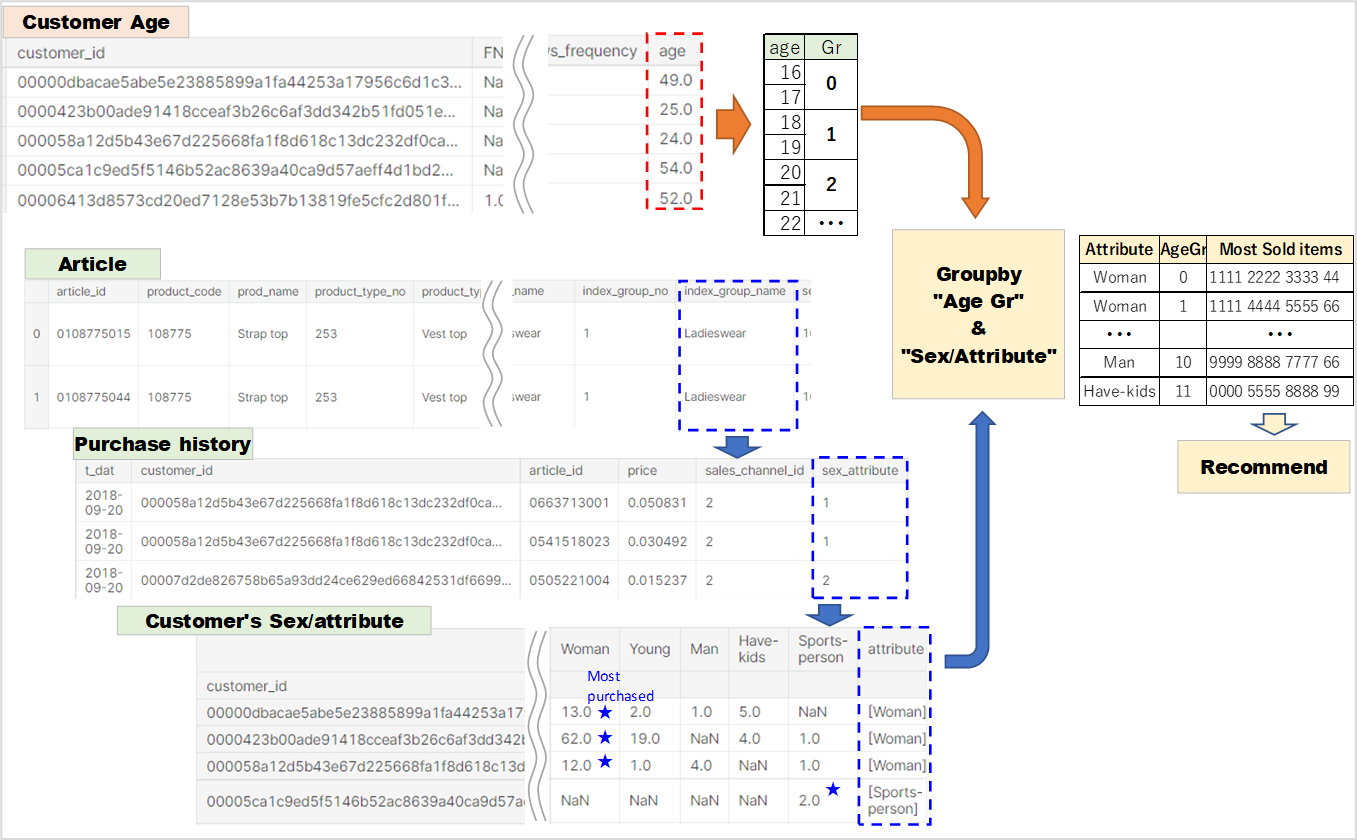

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, date, timedelta

from collections import Counter, defaultdict
from PIL import Image
from pathlib import Path

path = Path("/kaggle/input/h-and-m-personalized-fashion-recommendations/")

# 1. Reading Dataframes

In [ ]:
transactions_df = pd.read_csv(path / "transactions_train.csv", dtype = {'article_id': str})
articles_df = pd.read_csv(path / "articles.csv", dtype = {'article_id': str})
customers_df = pd.read_csv(path / "customers.csv")
submission = pd.read_csv(path / "sample_submission.csv")

Looks like the transaction(purchase) history is for 2-years from Sep-2018 to Sep-2020.  

取引履歴は、2018年9月から2020年9月までの2年分のようです。

In [ ]:
transactions_df["t_dat"] = pd.to_datetime(transactions_df['t_dat'])
transactions_df

As you see, the column to show Sexuality/Attribute does not exist in Customer data.

顧客データは、ご覧の通り、「性別（属性）」の項目が存在しない。

In [ ]:
customers_df

Age is mandatory for my approach this time, but there are many missings. Need to repair later.  

年齢は、今回のアプローチに必須なんですが、欠損値が結構ありそう。後で補修します。

In [ ]:
customers_df.isnull().sum()

# 2. Grouping by Age

As you can see in the histogram below, looks like young generation (Teens/20's) are more than 30's~, hence will be grouping as follows.  
  - for 10's and 20's, every 2-years
  - for 30's~50's, every 5-years
  - for 60's~, 1 group

以下のヒストグラムの通り、顧客層は20台が多いみたいなので、以下のように顧客層をグルーピングしたいと思います。  
　・10代・20代は「2歳ごと」  
 　・30代～50代は「5歳ごと」  
 　・60代以降は１グループ

In [ ]:
customers_df["age"].plot.hist(bins=50)

In [ ]:
age_id = 0
age_group = pd.DataFrame(columns =["age","age_id"])
age=16

for i in range(53) :
    if age < 30 :
        temp_group = pd.DataFrame({"age":[age, age+1], "age_id":[age_id, age_id]})
        age_group = age_group.append(temp_group)
        age += 2
        age_id += 1
    elif  age < 60 :
        temp_group = pd.DataFrame({"age":[age, age+1, age+2, age+3, age+4],"age_id":[age_id, age_id, age_id, age_id, age_id]})
        age_group = age_group.append(temp_group)
        age += 5
        age_id += 1
    else:
        temp_group = pd.DataFrame({"age":[age], "age_id":[age_id]})
        age_group = age_group.append(temp_group)
        age += 1

16-99 age will be grouped into age_id 0-13.   

16~99歳の年齢を0～13までのage_idにグルーピング

In [ ]:
age_group

In [ ]:
customers_df = pd.merge(customers_df, age_group, on="age", how = "left")
customers_df = customers_df.drop(["FN", "Active", "club_member_status", "fashion_news_frequency", "postal_code"], axis=1)
customers_df

# 3. Grouping by Sex/Attribute

**Approach**  
(1) Based on "index_group_name" in article list, Purchase history will be classified as "Women's item", "Men's item", "Kid's item", etc.  
(2) Based on the purchase history, classify the customers into 5 attributes, guessing those who purchased more Women's items are Women, and those who purchased more Men's items are Men, etc.  

**アプローチ**  
(1) 品目リストのindex_group_nameをもとに、購入履歴を女性用品・男性用品・子供用品等に分類  
(2) 女性用の購入履歴が多い顧客を女性、男性用の購入履歴が多い顧客を男性、という具合に顧客層を5つの属性に分類  
　　（女性　／　ヤング(Divided)　／　男性　／　子持ち　／　スポーツパーソン）

In [ ]:
articles_df.head(5)

As you can see, let's classify the customers into 5 attributes based on "index_group_name/no" in article list.  

以下の通り、品目リストに含まれている「index_group_name」「index_group_no」で５つの属性に顧客を分類。

In [ ]:
print(articles_df["index_group_name"].unique())
print(articles_df["index_group_no"].unique())

Looks like Women's items and Kid's items are much more than others... I see.

女性用品と子供用品が圧倒的に多いんだ。。ふ～ん

In [ ]:
sex_category = articles_df[["index_group_no", "index_group_name"]].reset_index()
display(sex_category["index_group_name"].value_counts())

In [ ]:
sex_category_list = sex_category["index_group_name"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(sex_category["index_group_name"].value_counts().sort_values(ascending=False), 
        labels = sex_category_list, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

In [ ]:
del sex_category_list

In [ ]:
articles_category_df = pd.DataFrame(articles_df[["article_id", "index_group_no"]])
articles_category_df.columns = ["article_id", "sex_attribute"]
articles_category_df

In [ ]:
transactions_df = pd.merge(transactions_df, articles_category_df, on = "article_id", how = "left")
transactions_df

Let's see which customer has been purchasing which categoy items.  

顧客id毎に、どのカテゴリーの品目の購入が多いかを見てみる。

In [ ]:
cust_sex = transactions_df[["customer_id", "sex_attribute", "article_id"]].groupby(["customer_id","sex_attribute"]).count().unstack()
cust_sex.columns = ["Woman", "Young", "Man", "Have-kids", "Sports-person"]
cust_sex

Classify the purchase history of each customer in 5 categories, and then, classify the customers into the attribute i which category items the customer have purchased the most.  

５つのカテゴリーに購入履歴を分類し、最も購入数が多かったカテゴリーに顧客を分類する。



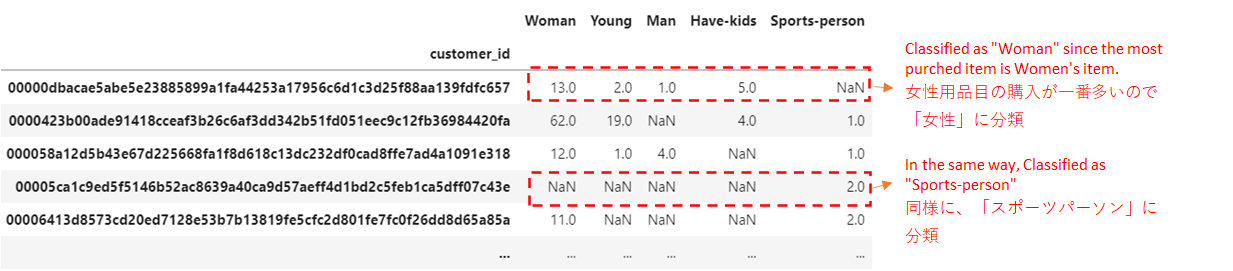

Set the max-value column into newly-ceated column "attribute" using the lambda below.  

以下のlambda式で各行の最大値をもつカラムを新設する「attribute」列に抽出する。

In [ ]:
%%time
cust_sex["attribute"] = cust_sex.apply(lambda x : list(x[x == x.max()].index), axis=1)
cust_sex

In [ ]:
cust_sex1 = pd.DataFrame(cust_sex[["attribute"]]).reset_index()
cust_sex1["attribute"] = cust_sex1["attribute"].apply(",".join).astype(str)
del cust_sex
cust_sex1

In case where the purchase history of multiple categories is the same such as the number of Women's items and Kid's items is the same, the attribute will have the multiple attributes.  
Since Woman is the most in the attribute, those who have multiple attributes will be classified as Woman.  

「女性用品と子供用品の購入回数が同じ」といった場合は、attributeは「Woman, Have-kids」という具合に複数セットされる。  
属性は圧倒的に女性が多いので、これら複数属性をもつ顧客は「女性」に分類する。

In [ ]:
print(cust_sex1.attribute.unique())

In [ ]:
cust_sex1.loc[~((cust_sex1["attribute"] == "Woman") |
               (cust_sex1["attribute"] == "Young")  |
               (cust_sex1["attribute"] == "Man")    |
               (cust_sex1["attribute"] == "Have-kids") |
               (cust_sex1["attribute"] == "Sports-person")), "attribute"] = "Woman"
cust_sex1

In [ ]:
print(cust_sex1.attribute.unique())

In [ ]:
temp = cust_sex1["attribute"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(cust_sex1["attribute"].value_counts().sort_values(ascending=False), 
        labels = temp, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

In [ ]:
print(cust_sex1["attribute"].value_counts().sort_values(ascending=False))

In [ ]:
customers_df = pd.merge(customers_df, cust_sex1, on ="customer_id", how="left")
customers_df

Those who have no puchased history and hence is not classified as any attribute will be classified as "Woman".  

購入履歴がないために属性が判定できなかった顧客も「女性」に分類する。

In [ ]:
customers_df.isnull().sum()

In [ ]:
customers_df["attribute"].fillna("Woman", inplace = True)

As we saw at the beginning of this notebook, there are many missings in Age. I'll repair them using the average age grouped by attribute.  

冒頭で見た通り、年齢に欠損値が多いので、属性毎に平均年齢を出して埋める。

In [ ]:
age_mean = customers_df[["age", "attribute"]].groupby("attribute").mean().round().reset_index()
age_mean.columns = ["attribute", "age_mean"]
age_mean

In [ ]:
customers_df = pd.merge(customers_df, age_mean, on = "attribute", how ="left")
customers_df.loc[(customers_df["age"].isnull()), "age"] = customers_df["age_mean"]
customers_df = customers_df.drop(["age_mean", "age_id"], axis =1)
customers_df = pd.merge(customers_df, age_group, on="age", how="left")
customers_df.isnull().sum()

In [ ]:
transactions_df = pd.merge(transactions_df, customers_df, on ="customer_id", how ="left")
transactions_df.isnull().sum()

In [ ]:
del cust_sex1

# 4. Make prediction

Since the target for prediction is 1-week transaction after training period finishes, we may not need to analyze the past transactions, therefore I'll try to use Sep-2020 transactions for prediction.  
(Update) When the transactions to be used for prediction is changed from "after 9/1" to "after 9/15", then Public Score was omproved from 0.0074--> 0.0078.

予測するのはトレーニング期間終了後の1週間なので、あまり過去の取引情報を見ても仕方ないと思い、2020年9月に入ってからの取引履歴を予想に使用する。  
（更新）予想に使用する取引履歴を「9/1以降」から「9/15以降」（トレーニング終了1週間前）に変更すると、Public Scoreは0.0074→0.0078に改善。


In [ ]:
transactions_df = transactions_df.loc[transactions_df.t_dat >= pd.to_datetime('2020-09-15')] # changed from 2020-09-01
transactions_df

Calculate the purchase counts per each age and attribute.  

年齢、属性ごとに各品目の購入数を算出。

In [ ]:
transactions_df.article_id = ' ' + transactions_df.article_id.astype('str')
temp = transactions_df.groupby(['age_id','attribute','article_id'])['customer_id'].agg('count').reset_index()
temp.columns = ['age_id','attribute','article_id','count']
transactions_df = transactions_df.merge(temp, on=['age_id','attribute','article_id'], how='left')
transactions_df

In [ ]:
transactions_df = transactions_df.sort_values(['count','t_dat'],ascending=False)
transactions_df = transactions_df.drop_duplicates(['age_id','attribute','article_id'])
transactions_df

Just FYI, the best item which was most sold in Sep-2020 is the below item,article_id 0915526001. Let's take a quick look.  
I see, looks very good!!

ちなみに、9月に一番売れたのは20・21歳の女性に売れたArticle番号0915526001の品目。ちょっと見てみよう。。。  
へぇ～、すごく良さそう！

In [ ]:
def show_images(article_ids, cols=1, rows=-1):
    if isinstance(article_ids, int) or isinstance(article_ids, str):
        article_ids = [article_ids]
    article_count = len(article_ids)
    if rows < 0: rows = (article_count // cols) + 1
    plt.figure(figsize=(3 + 3.5 * cols, 3 + 5 * rows))
    for i in range(article_count):
        article_id = ("0" + str(article_ids[i]))[-10:]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(article_id)
        try:
            image = Image.open(f"/kaggle/input/h-and-m-personalized-fashion-recommendations/images/{article_id[:3]}/{article_id}.jpg")
            plt.imshow(image)
        except:
            pass

In [ ]:
show_images("0915526001")

Sum up the items grouped by age_id and attribute, which was already sorted by sold counts above.  

予測用にage_id・attribute毎に上記の売れ筋順アイテムを合体させる。

In [ ]:
recommend_sex_age = pd.DataFrame(transactions_df.groupby(["age_id", "attribute"]).article_id.sum().reset_index())
recommend_sex_age["len"] = recommend_sex_age["article_id"].apply(lambda x : len(x))
recommend_sex_age

In [ ]:
recommend_sex_age["article_id"] = recommend_sex_age["article_id"].str.strip()
recommend_sex_age["article_id"] = recommend_sex_age["article_id"].str[:131]
recommend_sex_age = recommend_sex_age.drop(["len"], axis =1)

In [ ]:
submission = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
submission = submission[['customer_id']]
submission = pd.merge(submission, customers_df, on = "customer_id", how = "left")
submission = pd.merge(submission, recommend_sex_age, on = ["age_id", "attribute"], how="left")
submission = submission.drop(["age", "age_id", "attribute"], axis =1)
submission.columns = ("customer_id", "prediction")
submission.to_csv("submission.csv",index=False)
submission

Let's see recommendation for early 30's, just from curiosity.

ちなみに、完全に好奇心ですが、30代前半のおススメを見てみる。

In [ ]:
recommend_sex_age.loc[(recommend_sex_age["age_id"]==7), ]

Following is the recommended items for early 30's Women.

30代前半女性用のおススメアイテムがこちら

In [ ]:
show_images(recommend_sex_age.iloc[38, 2].split(), 6)

Also, below is the recommended items for early 30's Men...ok, I see.

同じく、30代前半男性用のおススメがこちら。まぁ、、納得

In [ ]:
show_images(recommend_sex_age.iloc[36, 2].split(), 6)